# Task 3

Imports

In [2]:
# stdlib
import os
from functools import partial

# pip
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras import backend as K

# local
from utils import get_dirs, train_test_split

Fix directories

In [3]:
DIRS = get_dirs(os.path.abspath('') + os.sep + 'Task2.ipynb')
print('\033[1m' + 'Directories:' + '\033[0m')
for dir_name, path in DIRS.items():
    print(f'{dir_name:<7} {path}')

Directories:
data    /Users/jdhamelink/Uni/DL/MCG/data/
results /Users/jdhamelink/Uni/DL/MCG/results/
csv     /Users/jdhamelink/Uni/DL/MCG/results/csv/
plots   /Users/jdhamelink/Uni/DL/MCG/results/plots/
figs    /Users/jdhamelink/Uni/DL/MCG/results/figs/
models  /Users/jdhamelink/Uni/DL/MCG/results/models/


Load and split data

In [4]:
images = np.load(DIRS['data'] + 'images.npy')
labels = np.load(DIRS['data'] + 'labels.npy')

images = images.astype('float32') / 255
labels = labels.astype('int32')

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X=images, y=labels, test_size=0.2)

del images, labels

print('\033[1m' + 'Data:' + '\033[0m')
print('  name  |        shape      | dtype')
print('--------+-------------------+-------')
for name, arr in zip(['X_train', 'X_test', 'y_train', 'y_test'], [X_train, X_test, y_train, y_test]):
    print(f'{name:<7} | {str(arr.shape):<17} | {arr.dtype}')

Data:
  name  |        shape      | dtype
--------+-------------------+-------
X_train | (14400, 150, 150) | float32
X_test  | (3600, 150, 150)  | float32
y_train | (14400, 2)        | int32
y_test  | (3600, 2)         | int32


Define functions to get specific versions of the labels

In [5]:
def get_regression_labels(y_train, y_test):
    """
    Hours and minutes are merged into a single float value:
        * (1, 30) -> 1.5
        * (11, 15) -> 11.25
    """
    reg_y_train = (y_train[:, 0] + y_train[:, 1] / 60).astype('float32')
    reg_y_test  = (y_test[:, 0] + y_test[:, 1] / 60).astype('float32')
    return reg_y_train, reg_y_test

def get_class_24_labels(y_train, y_test):
    """
    12 hours are split into 24 half-hour bins:
        * (1, 30) -> 3 (one-hot vector)
        * (11, 15) -> 22 (one-hot vector)
    """
    class_y_train = (y_train[:, 0] * 2 + y_train[:, 1] // 30).astype('float32')
    class_y_test  = (y_test[:, 0] * 2 + y_test[:, 1] // 30).astype('float32')
    class_y_train = keras.utils.to_categorical(class_y_train, num_classes=24)
    class_y_test = keras.utils.to_categorical(class_y_test, num_classes=24)
    return class_y_train, class_y_test

def get_class48_labels(y_train, y_test):
    """
    12 hours are split into 48 quarter-hour bins:
        * (1, 30) -> 6 (one-hot vector)
        * (11, 15) -> 45 (one-hot vector)
    """
    class_y_train = (y_train[:, 0] * 4 + y_train[:, 1] // 15).astype('float32')
    class_y_test  = (y_test[:, 0] * 4 + y_test[:, 1] // 15).astype('float32')
    class_y_train = keras.utils.to_categorical(class_y_train, num_classes=48)
    class_y_test = keras.utils.to_categorical(class_y_test, num_classes=48)
    return class_y_train, class_y_test

def get_mixed_labels(y_train, y_test):
    """
    Hours are returned as one-hot vectors and minutes are returned as just floats.
    Notice that the returned variables are tuples.
    """
    # TODO: Correctly implement this function
    hours_train = keras.utils.to_categorical(y_train[:, 0], num_classes=12)
    hours_test  = keras.utils.to_categorical(y_test[:, 0], num_classes=12)
    minutes_train = y_train[:, 1].astype('float32')
    minutes_test  = y_test[:, 1].astype('float32')
    return (hours_train, minutes_train), (hours_test, minutes_test)

Define custom loss function where 0:00 and 11:55 are just 5 minutes apart

In [7]:
def cs_loss(y_true, y_pred):
    """Common sense loss"""
    # punish negative predictions and predictions greater than 12
    penalty = K.maximum(0.0, -y_pred) + K.maximum(0.0, y_pred - 12)
    loss = K.minimum(K.abs(y_true - y_pred), K.ones_like(y_true) * 12 - K.abs(y_true - y_pred))
    return loss + penalty

tests = [[1.0, 1.0], [1.5, 1.25], [11.75, 0.25], [0.0, 6.0], [0.0, 6.25], [2.0, -10.0], [1.0, -1.0]]
print('\033[1m' + 'Common sense loss:' + '\033[0m')
print(' true | pred  | loss')
print('------+-------+-----')
for test in tests:
    print(f'{test[0]:<5} | {test[1]:<5} | {cs_loss(test[0], test[1])}')

Common sense loss:
 true | pred  | loss
------+-------+-----
1.0   | 1.0   | 0.0
1.5   | 1.25  | 0.25
11.75 | 0.25  | 0.5
0.0   | 6.0   | 6.0
0.0   | 6.25  | 5.75
2.0   | -10.0 | 2.0
1.0   | -1.0  | 1.0


Define function that can build models for all of the different approaches to the problem

In [80]:
def build_model(problem_type: str) -> keras.Model:
    """
    Build and compile a model for the given problem type.
    
    Options:
        * 'nrg' | naive regression
        * 'csr' | common sense regression
        * 'c24' | classification into 24 half-hour bins
        * 'c48' | classification into 48 quarter-hour bins
        * 'mhm' | multi-head model: 12 hour bins (classification), minutes with common sense regression
    """
    
    if problem_type == 'nrg':
        final_layer = layers.Dense(1)
        loss, metrics = 'mse', ['mae']
    elif problem_type == 'csr':
        final_layer = layers.Dense(1)
        loss, metrics = cs_loss, ['mae']
    elif problem_type in ['c24', 'c48']:
        final_layer = layers.Dense(24 if problem_type == 'c24' else 48, activation='softmax')
        loss, metrics = 'categorical_crossentropy', ['accuracy']
    elif problem_type == 'mhm':
        raise NotImplementedError('Multi-head model is not implemented yet.')
        final_layer = [layers.Dense(12, activation='softmax'), layers.Dense(1)]
        loss, metrics = ['categorical_crossentropy', cs_loss], ['accuracy', 'mae']
    else:
        raise ValueError(f'Unknown problem type: {problem_type}')

    DefaultConv2D = partial(layers.Conv2D, kernel_initializer='he_normal', kernel_size=3, activation='elu', padding='SAME')
    
    model = Sequential()
    model.add(DefaultConv2D(filters=32, kernel_size=5, strides=(3, 3), input_shape=(150, 150, 1)))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(DefaultConv2D(filters=64))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(DefaultConv2D(filters=128))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(final_layer)

    model.compile(loss=loss, optimizer='adam', metrics=metrics)
    
    return model

In [81]:
def run_experiment(
    problem_type: str,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    save_model: bool = False
    ) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Run an experiment for the given problem type.
    
    Options:
        * 'nrg' | naive regression
        * 'csr' | common sense regression
        * 'c24' | classification into 24 half-hour bins
        * 'c48' | classification into 48 quarter-hour bins
        * 'mhm' | multi-head model: 12 hour bins (classification), minutes with common sense regression

    Returns:
        * loss history (train)
        * metric history (train)
        * test results

    For the multi-head model, five dataframes are returned

    If save_model is True, the model is saved to a `.h5` file.
    """
    
    if problem_type in ['nrg', 'csr']:
        y_train, y_test = get_regression_labels(y_train, y_test)
    elif problem_type == 'c24':
        y_train, y_test = get_class_24_labels(y_train, y_test)
    elif problem_type == 'c48':
        y_train, y_test = get_class48_labels(y_train, y_test)
    # TODO: implement multi-head model
    elif problem_type == 'mhm':
        raise NotImplementedError('Multi-head model not implemented yet.')
        y_train, y_test = get_mixed_labels(y_train, y_test)
    else:
        raise ValueError(f'Unknown problem type: {problem_type}')
    
    model = build_model(problem_type)
    reps = 5
    folds = 5
    fold_size_train = X_train.shape[0] // folds
    fold_size_test = X_test.shape[0] // folds

    # df_train_loss will be a list with each row representing an epoch, and each column representing a fold
    # df_train_metric will be a list with each row representing an epoch, and each column representing a fold
    df_train_loss = pd.DataFrame()
    df_train_metric = pd.DataFrame()

    # for the multi-head model, we'll need two more dataframes
    if problem_type == 'mhm':
        df_train_loss2 = pd.DataFrame()
        df_train_metric2 = pd.DataFrame()
    
    # df_test will have each row representing a fold, with the columns being loss, metric (and loss2, metric2 for the multi-head model)
    df_test = pd.DataFrame(columns=['loss', 'metric'])
    if problem_type == 'mhm':
        df_test = pd.DataFrame(columns=['loss', 'metric', 'loss2', 'metric2'])

    for rep in range(reps):
        print('\n' + '\033[1m' + '-' * 50 + '\n' + f'Pass {fold+1}/{folds}' + '\033[0m')
        for fold in range(folds):
            print(f'\n---\n' + '\033[1m' + f'Fold {fold+1}/{folds}' + '\033[0m' + '\n')
            X_train_fold = X_train[fold * fold_size_train : (fold + 1) * fold_size_train]
            X_test_fold = X_test[fold * fold_size_test : (fold + 1) * fold_size_test]
            y_train_fold = y_train[fold * fold_size_train : (fold + 1) * fold_size_train]
            y_test_fold = y_test[fold * fold_size_test : (fold + 1) * fold_size_test]

            # train the model
            history = model.fit(X_train_fold, y_train_fold, epochs=10, verbose=1)

            # evaluate the model
            results = model.evaluate(X_test_fold, y_test_fold, verbose=1)

            # save the results
            # TODO: check if this also works for mhm
            df_test.loc[rep*folds + fold] = results
            df_train_loss[rep*folds + fold] = history.history['loss']
            df_train_metric[rep*folds + fold] = history.history[list(history.history.keys())[1]]
            # TODO: same same
            if problem_type == 'mhm':
                df_train_loss2[rep*folds + fold] = history.history['loss2']
                df_train_metric2[rep*folds + fold] = history.history[list(history.history.keys())[3]]

        # save the model after each rep
        if save_model:
            model.save(DIRS['models'] + f'{problem_type}.h5')
        
    if problem_type == 'mhm':
        return df_train_loss, df_train_metric, df_train_loss2, df_train_metric2, df_test
    return df_train_loss, df_train_metric, df_test

In [ ]:
df_train_loss, df_train_metric, df_test = run_experiment('csr', X_train, y_train, X_test, y_test, save_model=True)

df_train_loss.to_csv(DIRS['csv'] + 'cse_train_loss.csv')
df_train_metric.to_csv(DIRS['csv'] + 'cse_train_metric.csv')
df_test.to_csv(DIRS['csv'] + 'cse_test.csv')

In [72]:
model = keras.models.load_model(DIRS['models'] + 'csr.h5', custom_objects={'cs_loss': cs_loss})

In [73]:
# predict the test set
y_pred = model.predict(X_test)
# get regression labels
_, y_true = get_regression_labels(y_train, y_test)

2022-11-26 12:39:17.316092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


113/113 [==============================] - 2s 16ms/step


In [74]:
df = pd.DataFrame(columns=['true', 'pred'])
df['true'] = y_true
df['pred'] = y_pred


# cluster into three groups with sklearn
from sklearn.cluster import DBSCAN
kmeans = DBSCAN().fit(df[['true', 'pred']])
df['cluster'] = kmeans.labels_

# fit a linear regression model to each cluster
from sklearn.linear_model import LinearRegression
lr1 = LinearRegression()
lr1.fit(df[df['cluster'] == 0][['true']], df[df['cluster'] == 0]['pred'])
df['pred_lr_1'] = lr1.predict(df[['true']])
lr2 = LinearRegression()
lr2.fit(df[df['cluster'] == 1][['true']], df[df['cluster'] == 1]['pred'])
df['pred_lr_2'] = lr2.predict(df[['true']])
lr3 = LinearRegression()
lr3.fit(df[df['cluster'] == 2][['true']], df[df['cluster'] == 2]['pred'])
df['pred_lr_3'] = lr3.predict(df[['true']])


In [75]:
df

,true,pred,cluster,pred_lr_1,pred_lr_2,pred_lr_3
0,1.700000,12.542371,0,11.644758,2.118444,1.181201
1,4.983333,6.359713,1,11.148889,5.117018,2.175663
2,6.133333,4.041011,1,10.975208,6.167280,2.523977
3,3.633333,4.183219,1,11.352774,3.884102,1.766773
4,0.483333,0.969180,1,11.828506,1.007297,0.812695
...,...,...,...,...,...,...
3595,6.616667,7.510702,1,10.902212,6.608695,2.670370
3596,6.150000,-5.217067,6,10.972691,6.182501,2.529025
3597,9.450000,2.667054,11,10.474304,9.196297,3.528535
3598,9.250000,7.272357,1,10.504509,9.013642,3.467959


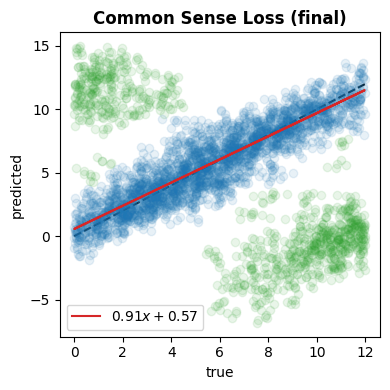

In [78]:
fig, ax = plt.subplots(figsize=(4, 4))
# plot clusters
n_clusters = len(np.unique(df['cluster']))
clusters = [df[df['cluster'] == i] for i in range(n_clusters)]
main_cluster_i = np.argmax([len(cluster) for cluster in clusters])
main_cluster = clusters[main_cluster_i]
for i, cluster in enumerate(clusters):
    color = 'tab:blue' if i == main_cluster_i else 'tab:green'
    ax.plot(cluster['true'], cluster['pred'], 'o', alpha=0.1, zorder=2, color=color)

# plot the linear regression
lr = LinearRegression()
lr.fit(main_cluster[['true']], main_cluster[['pred']])
# predict on true
pred = lr.predict(main_cluster[['true']])
# plot
ax.plot(main_cluster['true'], pred, '-', color='tab:red', zorder=3, label=f'${lr.coef_[0][0]:.2f}x + {lr.intercept_[0]:.2f}$')

# plot diagonal
ax.plot([0, 12], [0, 12], zorder=1, color='black', linestyle='--')

ax.legend()
ax.set_xlabel('true')
ax.set_ylabel('predicted')
ax.set_title('Common Sense Loss (final)', weight='bold')
fig.tight_layout()
plt.savefig('../results/plots/csf_acc.png', dpi=300)